# GxE problem

- I updated the simulation function so that sigma is always positive (exponential)
- I am adding the decomposition of the effects
- 100 replicates per scenario

### Next steps

- Find specifications where the test would be misleading

In [ ]:
library(brms)
library(data.table)
library(texreg)
library(future)
plan(multicore)
source("../src/utils.R")

In [2]:
# scaling model 
simScaling = function(E, a0 = 0, a1 = 0.5, b0 = 0.8, b1 = 0.2, h = sqrt(0.6)) {
    N = length(E)
    G = rnorm(N,0,1)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    eps = rnorm(N, 0, sigma)
    y = a0 + a1*E + b0*h*G + b1*h*E*G + eps
    df = data.frame(E = E, y = y, g = G)
}

# interaction model
simInteraction = function(E, a0 = 0.0, b1 = 0.5, b2 = 0.2, b3 = 0.15, sb0 = 0.1, sb1 = 0.4) {
    N = length(E)
    G = rnorm(N,0,1)
    sigma = exp(sb0 + sb1 * E) 
    eps = rnorm(N, 0, sigma)
    y = a0 + b1*G + b2*E + b3*G*E + eps
    df = data.frame(E = E, y = y, g = G)
}

# interaction + scaling model
simScalingInteraction = function(E, a0 = 0.0,  a1 = 0.5, a2 = 0.10, b0 = 0.8, b1 = 0.2, h = sqrt(0.6)) {
    N = length(E)
    G = rnorm(N,0,1)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    eps = rnorm(N, 0, sigma)
    y = a0 + a1*E + a2*G*E + b0*h*G + b1*h*E*G + eps
    df = data.frame(E = E, y = y, g = G)
}

## Simulating data

In [3]:
E = rnorm(2000, 0, 1)
replicates = 100
dts = replicate(replicates, simScaling(E), simplify = FALSE)
dti = replicate(replicates, simInteraction(E), simplify = FALSE)
dtsi = replicate(replicates, simScalingInteraction(E), simplify = FALSE)

In [5]:
cnames = c("Scaling", "Interaction", "Scaling + Interaction")
m1 = lm(y ~ g + E + g * E, data = dts[[1]])
m2 = lm(y ~ g + E + g * E, data = dti[[1]])
m3 = lm(y ~ g + E + g * E, data = dtsi[[1]])
cat(screenreg(list(m1, m2, m3), custom.model.names = cnames))


             Scaling      Interaction  Scaling + Interaction
------------------------------------------------------------
(Intercept)     0.01         0.02         0.04              
               (0.04)       (0.03)       (0.04)             
g               0.61 ***     0.53 ***     0.62 ***          
               (0.04)       (0.03)       (0.04)             
E               0.50 ***     0.22 ***     0.49 ***          
               (0.04)       (0.03)       (0.04)             
g:E             0.14 ***     0.16 ***     0.27 ***          
               (0.04)       (0.03)       (0.04)             
------------------------------------------------------------
R^2             0.18         0.18         0.20              
Adj. R^2        0.18         0.18         0.19              
Num. obs.    2000         2000         2000                 
*** p < 0.001; ** p < 0.01; * p < 0.05



# Bayesian distributional model


In [ ]:
# distributional model using bayesian stats
f = bf(y ~ g + E + g * E, sigma ~ 1 + E)
b1 = brm_multiple(f, data = dts, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b2 = brm_multiple(f, data = dti, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b3 = brm_multiple(f, data = dtsi, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)

In [ ]:
# checking convergence of models
rb1 = unlist(b1$rhats)
rb2 = unlist(b2$rhats)
rb3 = unlist(b3$rhats)
print(table(rb1 > 1.05 | rb1 < 0.95))
print(table(rb2 > 1.05 | rb2 < 0.95))
print(table(rb3 > 1.05 | rb3 < 0.95))


FALSE 
  700 

FALSE 
  700 

FALSE 
  700 


In [14]:
# able to recover the correct sigma coefficients 
suppressWarnings(cat(screenreg(list(b1, b2, b3), custom.model.names = cnames, 
    use.HDI = TRUE,
    include.rsquared = FALSE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    include.waic = FALSE)))


                 Scaling        Interaction    Scaling + Interaction
--------------------------------------------------------------------
Intercept          -0.01          -0.00          -0.00              
                 [-0.09; 0.08]  [-0.07; 0.06]  [-0.09; 0.08]        
sigma_Intercept     0.51 *         0.10 *         0.51 *            
                 [ 0.47; 0.54]  [ 0.06; 0.14]  [ 0.47; 0.54]        
g                   0.62 *         0.50 *         0.62 *            
                 [ 0.53; 0.71]  [ 0.44; 0.57]  [ 0.53; 0.71]        
E                   0.50 *         0.20 *         0.50 *            
                 [ 0.41; 0.58]  [ 0.15; 0.25]  [ 0.42; 0.59]        
g:E                 0.15 *         0.15 *         0.25 *            
                 [ 0.07; 0.24]  [ 0.10; 0.20]  [ 0.17; 0.34]        
sigma_E             0.13 *         0.40 *         0.13 *            
                 [ 0.09; 0.16]  [ 0.36; 0.43]  [ 0.09; 0.16]        
---------------------------------

# Tests

## Scaling

In [15]:
# I cannot reject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b1, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0        0      0.03    -0.05     0.06         NA
  Post.Prob Star
1        NA     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

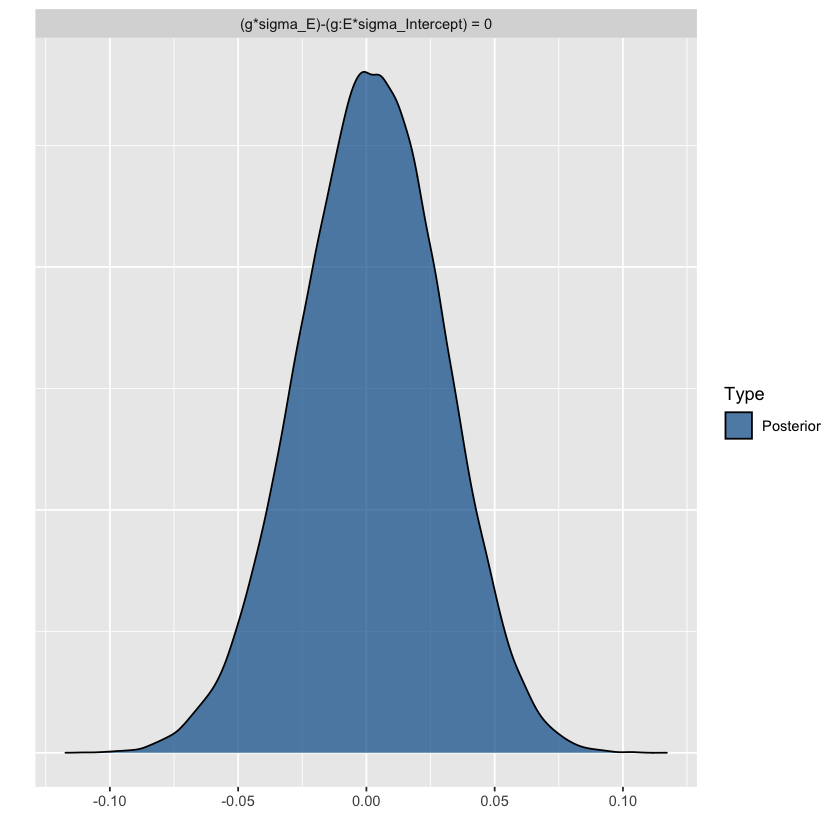

In [16]:
plot(hyp)

## Interaction

In [17]:
# I reject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b2, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0     0.19      0.02     0.15     0.22         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

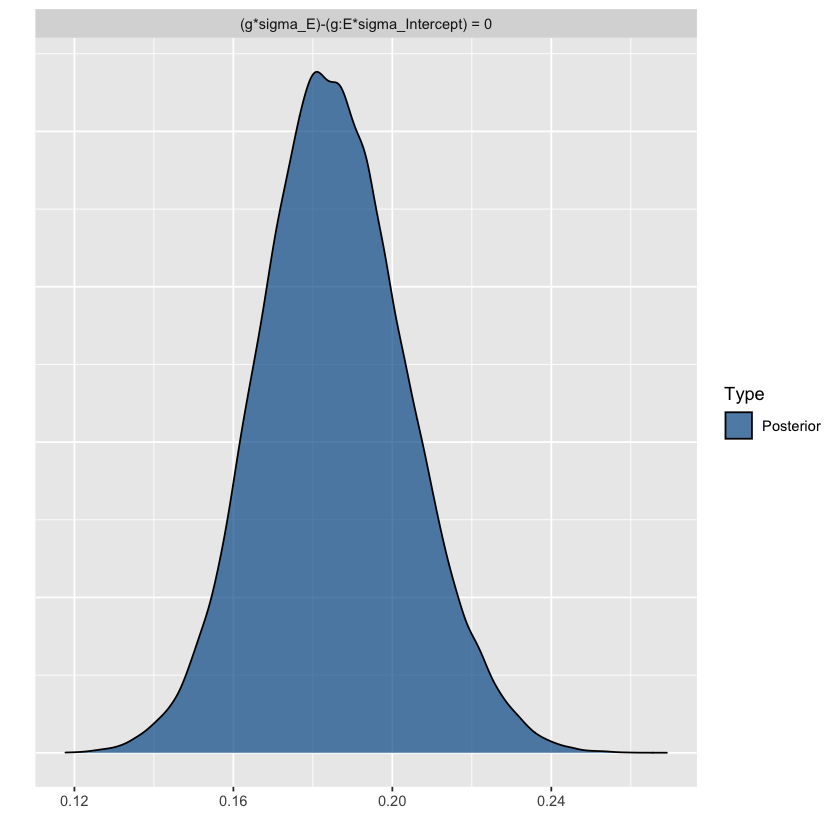

In [18]:
plot(hyp)

## Interaction + Scaling

In [21]:
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b3, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0    -0.05      0.03    -0.11     0.01         NA
  Post.Prob Star
1        NA     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

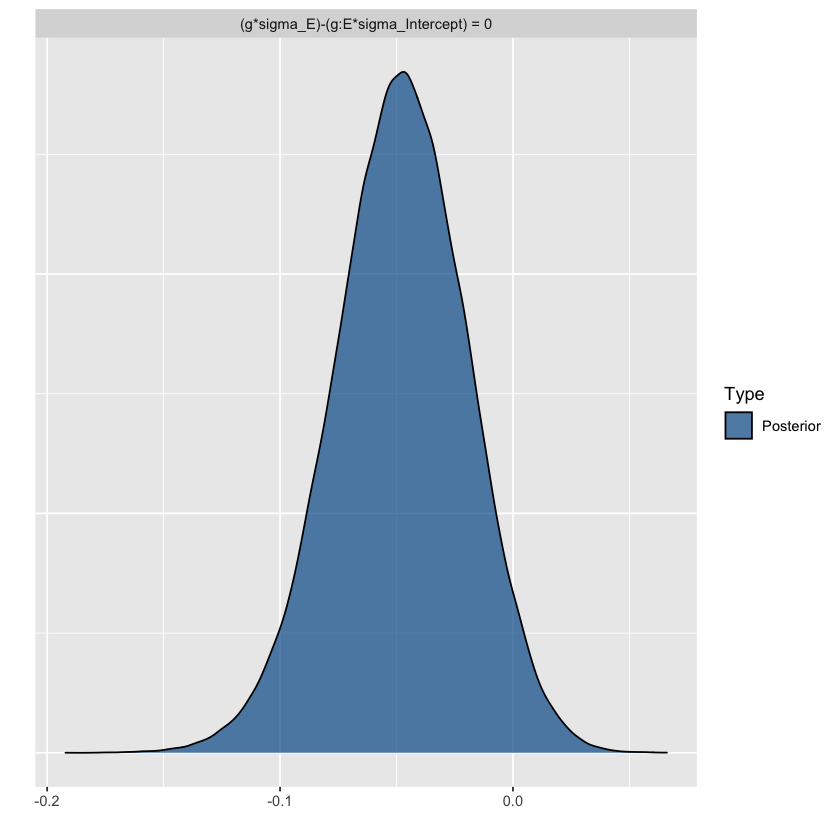

In [22]:
plot(hyp)

In [23]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hyp <- "1.0 = g:E / (g:E + sigma_E)"
(hyp <- hypothesis(b3, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (1.0)-(g:E/(g:E+s... = 0     0.34      0.06     0.23     0.47         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

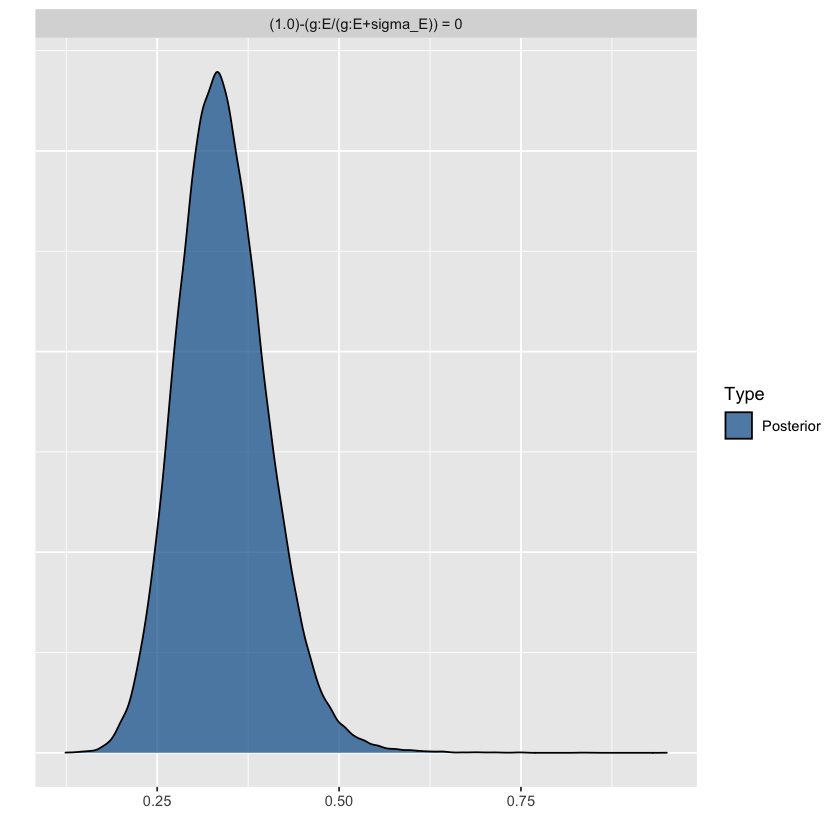

In [24]:
plot(hyp)

# A more complex heritability function

$$ V_P = V_G + V_E + Cov(V_G, V_E) + V_{HD}$$

- G = Genetic info
- E = Enviroment
- HD = Developmental noise

In [138]:
# simulation variables
simComplexH = function(E, a = 0.0, a1 = 0.1, b0 = 0.1, b1 = 0.2, 
    hg = 0.3, he = 0.3, hge = 0.2) {
    
    n = length(E)
    G = rnorm(n)

    hd = 1 - (hg + he + hge)
    print(paste0("Total sum of coefficients: ", sum(hg, he, hge, hd)))   

    hg = sqrt(hg)
    he = sqrt(he)
    hge = sqrt(hge)
    hd = sqrt(hd)
    
    ys = hg * G + he * E + hge * G * E

    print(paste0("Sigma intercept: ", b0*hd))
    print(paste0("Sigma slope: ", b1 * hd))
    sigma = exp(b0 * hd  + b1 * hd * E)
    eps = rnorm(n, 0, sigma)
    y = a + a1 * E + (b0 + b1 * E) * ys + eps
    dat = data.table(y, G, E)
}

In [ ]:
E = rnorm(5000)
dd = replicate(10, simComplexH(E), simplify = FALSE)

In [153]:
cat(screenreg(list( 
    lm(y ~ G + E + E*G, data = dd[[1]]))))


             Model 1    
------------------------
(Intercept)     0.10 ***
               (0.02)   
G               0.14 ***
               (0.02)   
E               0.14 ***
               (0.02)   
G:E             0.14 ***
               (0.02)   
------------------------
R^2             0.05    
Adj. R^2        0.05    
Num. obs.    5000       
*** p < 0.001; ** p < 0.01; * p < 0.05


In [ ]:
f = bf(y ~ G + E + E * G, sigma ~ E)
test = brm_multiple(f, data = dd)

In [156]:
suppressWarnings(cat(screenreg(test, 
    include.rsquared = FALSE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    reloo = FALSE,
    include.waic = FALSE)))


                 Model 1     
-----------------------------
Intercept           0.11 *   
                 [0.07; 0.14]
sigma_Intercept     0.06 *   
                 [0.04; 0.08]
G                   0.14 *   
                 [0.10; 0.17]
E                   0.12 *   
                 [0.09; 0.15]
G:E                 0.12 *   
                 [0.08; 0.16]
sigma_E             0.09 *   
                 [0.07; 0.12]
-----------------------------
Num. obs.        5000        
* 0 outside the confidence interval.


In [157]:
hyp <- "G * sigma_E = G:E * sigma_Intercept"
(hyp <- hypothesis(test, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (G*sigma_E)-(G:E*... = 0        0         0        0     0.01         NA
  Post.Prob Star
1        NA     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

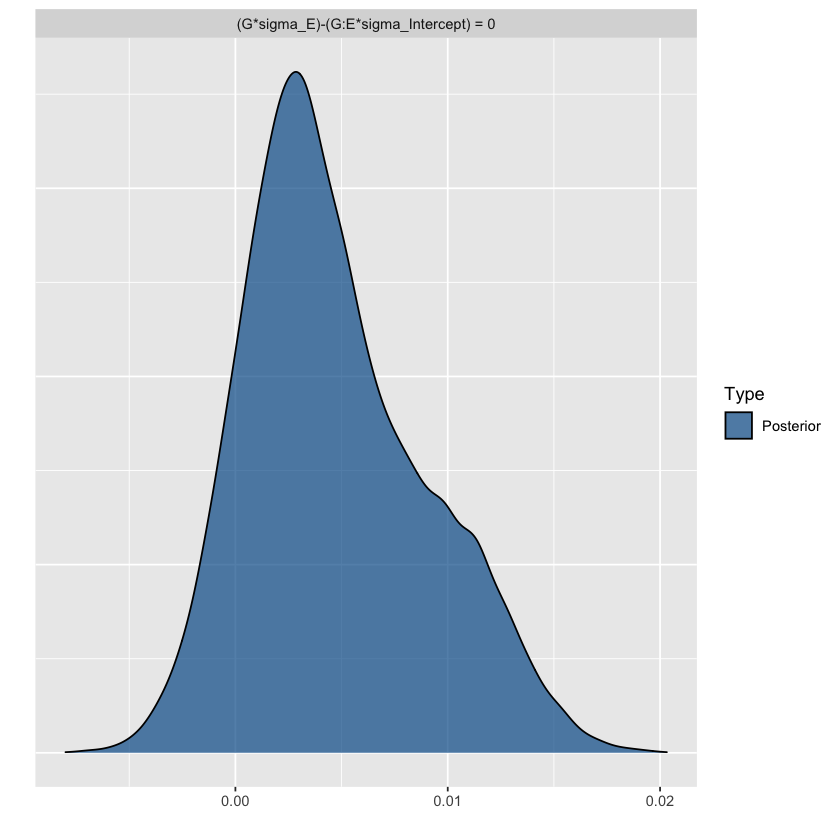

In [158]:
plot(hyp)

In [161]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hyp <- "1.0 = G:E / (G:E + sigma_E)"
(hyp <- hypothesis(test, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (1.0)-(G:E/(G:E+s... = 0     0.43      0.07      0.3     0.58         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.